# ASTR 211 - HW05 - Sadie Seddon-Stettler

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from codes.cosmology import d_L_vectorized
from codes.constants import clight
from codes.plot_utils import plot_pretty, plot_2d_dist
plot_pretty(fontsize=12)

from scipy.special import gamma
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize, differential_evolution

from timeit import default_timer

In [2]:
zCMB, mB, emB, x1, ex1, csn, ecsn = np.loadtxt('data/jla_lcparams.txt', 
                                               usecols=(1, 4, 5, 6, 7, 8, 9), unpack=True)

print("read sample of %d supernovae..."%(np.size(zCMB)))

read sample of 740 supernovae...


## Task 1a

In [3]:
Om0min, Om0max = 0., 1.
OmLmin, OmLmax = 0., 1.

nOm0 = 13; nOmL = 9
Om0tr = Om0min + (Om0max-Om0min) * np.linspace(0.,1.,nOm0)**2 # square-law 
OmLtr = OmLmin + (OmLmax-OmLmin) * (1.- np.linspace(0.,1.,nOmL)**1.75)
# the values of OmLtr are in descending order, so reverse the order before use
OmLtr = OmLtr[::-1]

nSN = np.size(zCMB)

dLgrid = np.zeros((nSN, nOm0, nOmL))
H0 = 70.
H0c = H0 / clight

tstart = default_timer()
atol = 5.e-16; rtol = 5e-16
for i, Omd in enumerate(Om0tr):
    for j, Omld in enumerate(OmLtr):
        # cancel the c/H0 factor to tabulate d_L without it
        dLgrid[:,i,j] = H0c * d_L_vectorized(zCMB, H0, Omd, Omld, atol=atol, rtol=rtol)

print("finished in %.3g sec"%(default_timer()-tstart))

finished in 12.8 sec


In [4]:
dLz = []
tstart = default_timer()
for iz, zi in enumerate(zCMB):
    #construct approximation for tilde(d)_L(z_i, Om0, OmL)
    spl2d = RectBivariateSpline(Om0tr, OmLtr, dLgrid[iz], s=0, kx=3, ky=3)
    dLz.append(spl2d)

print("finished in %.3g sec"%(default_timer()-tstart))
dLz = np.asarray(dLz)

finished in 0.0297 sec


In [5]:
def chi2(x):
    mu_model = np.zeros(nSN)
    for i in range(nSN): 
        mu_model[i] = 5.*np.log10(dLz[i](x[0], x[1])) 

    delta_mu_2 = (mB - (mu_model + x[2]) + x[3]*x1 - x[4]*csn)**2
    sig_2 = (emB**2) + (x[3]**2)*(ex1**2) + (x[4]**2)*(ecsn**2)
    return np.sum(delta_mu_2/sig_2)

In [6]:
def ln_L(x):
    chi_2 = chi2(x)
    sig_2 = (emB**2) + (x[3]**2)*(ex1**2) + (x[4]**2)*(ecsn**2)
    ln = np.sum(np.log(2*np.pi*sig_2))
    return (-1/2)*(chi_2 + ln)

In [7]:
def neg_2_lnL(x):
    return -2*ln_L(x)

## Task 1b

In [8]:
tstart = default_timer()
b = [(0, 1), (0, 1), (20, 28), (0.05, 0.3), (1., 5.)]
res = differential_evolution(neg_2_lnL, bounds=b)
print("completed in %.3g sec"%(default_timer() - tstart))
print("minimum at :",res.x)

ln_Lmin = ln_L(res.x)
print("-2lnL min = %.4e"%ln_Lmin)

completed in 5.84 sec
minimum at : [ 0.25750229  0.63497673 24.07862849  0.11942642  2.57935748]
-2lnL min = 3.3830e+02


Previously, our derived value for Omega0 was 0.394, and our tM0 value was 24.1. These are both very similar to the new values (of 0.257 and 24.07 respectively). However, our new Omega0 is 0.635, quite different from our previously derived value of 0.363.

## Task 1c

In [9]:
x = [0.25752049, 0.63500829, 24.07862607, 0.11942735, 2.57935899]
red_chi2 = chi2(x) / (nSN - 3)
print("reduced chi2 =", red_chi2)

reduced chi2 = 0.9316979440494364


Since this $chi^2$ value is very close to 1, this suggests that our model describes the supernova measurements well - almost to the point of overfitting (if it were below 0.8, I would start to worry about overfitting), but not there. The $chi^2$ value of our previous model was around 6, so this suggests that the 5-parameter model describes the measurements much better than the 3-parameter model.

## Task 1d

In [10]:
def ln_prior_pdf(x, args = None):
    px0, px1, px2, px3, px4 = (0, 0, 0, 0, 0)
    if 0 <= x[0] <= 1:
        px0 = 1
    if 0 <= x[1] <= 1:
        px1 = 1
    if 20 <= x[2] <= 28:
        px2 = .125
    if 0.05 <= x[3] <= 0.3:
        px3 = 4
    if 1 <= x[4] <= 5:
        px4 = .25
    if px0*px1*px2*px3*px4 == 0:
        return -3000
    else:
        return np.log(px0*px1*px2*px3*px4)

def posterior_pdf(x, args = None):
    return ln_prior_pdf(x) + ln_L(x)

def neg_post_pdf(x):
    return posterior_pdf(x)*(-1)

In [11]:
def vectorized_mcmc(x, nsteps=1, step=0.1, modelpdf = None, args = None):
    """
    MCMC sampler implementing a simple Metropolis algorithm
    to follow a number of chains ("walkers") in parallel
    
    This version also can sample distributions of arbitrary number of 
    dimensions ndim
    
    Parameters:
    ------------
    x0 - a real numpy array of size [nwalkers,ndim]
        initial x value
    nsteps - integer
        number of MCMC steps (iterations) to take
    step - float
        step size controlling step proposal distribution
    modelpdf - python function object
        ln(pdf) where pdf is the target pdf to sample
    args - pointer to a list
        list of arguments to pass modelpdf
        
    Returns:
    ---------
    xchain - numpy array of size [nsteps*nwalkers, ndim]
        coordinates of samples in the MCMC chains of size
    pacc   - float
        acceptance ratio of the MCMC steps (ratio of accepted to the total proposed number of steps)
    
    """
    
    # the input array here contains initial values for multiple MCMC sequences
    # or "walkers" in the MCMC jargon (because they "walk" the multi-d space of our target pdf)
    nwalkers = np.shape(x)[0]
    # make sure input is sensible
    assert(nwalkers>0)
    
    # number of dimensions that we will be sampling
    ndim = np.shape(x)[1]
        
    # initialize some auxiliary arrays and variables 
    chain = x;

    naccept = 0; ntry = 0; nchain = 0
    # initialize arrays that will be used to hold pdf values of samples
    # at old and proposed sample locations
    gxold = np.empty(nwalkers)
    gxtry = np.empty(nwalkers)
    for i in range(nwalkers):
        gxold[i] = modelpdf(x[i,:], *args)
    eps = 2.e-16
    
    nsample = 0 
    while nsample < nsteps:
        # proposal step using uniform pdf in range [-step, step]
        xtry  = x + step*np.random.uniform(-step, step, np.shape(x)) 
        for i in range(nwalkers):
            gxtry[i] = modelpdf(xtry[i,:], *args) 
        gx = np.copy(gxold) 
        # compare pdf values at the old and proposed sample locations  
        gr   = gxtry - gx
        u = np.random.uniform(eps,1.0,np.shape(x)[0])
        # accept proposal with probability min[1.0, e^gr]
        iacc = np.where(gr > np.log(u))
        # update those "walkers" for which proposal step was accepted 
        x[iacc,:] = xtry[iacc,:]
        gxold[iacc] = gxtry[iacc]
        naccept += np.size(gxtry[iacc])
        # add all walkers to the chain, regardless of whether their proposal step was accepted
        chain = np.vstack((chain, x))
        nsample += 1

    return chain, 1.*naccept/(nsample*nwalkers)

In [12]:
snbounds=[(0,1), (0,1), (20, 28), (0.05, 0.3), (1, 5)]

x0 = differential_evolution(neg_post_pdf, bounds=snbounds)

print(x0)

     fun: -336.220245614143
     jac: array([-0.00184741,  0.00226805,  0.00998739, -0.00132445,  0.0014154 ])
 message: 'Optimization terminated successfully.'
    nfev: 1857
     nit: 22
 success: True
       x: array([ 0.25752019,  0.63500882, 24.07862644,  0.11942718,  2.57936596])


In [13]:
ndim = 5
nwalkers = 100
nsteps = 1000
step = 1.
args0 = []

#differential evolution yielded [ 0.25747937,  0.63495553, 24.07862841,  0.11942547,  2.5793592 ]
x0 = np.zeros((ndim, nwalkers))
for i in range(nwalkers):
    x0[0][i] = np.random.normal(0,1) + 0.25747937
    x0[1][i] = np.random.normal(0,1) + 0.63495553
    x0[2][i] = np.random.normal(0,1) + 24.07862841
    x0[3][i] = np.random.normal(0,1) + 0.11942547
    x0[4][i] = np.random.normal(0,1) + 2.5793592

tstart = default_timer()

xchain, pacc0 = vectorized_mcmc(x0, nsteps=nsteps, step=step, modelpdf = posterior_pdf, args = args0 )

tend = default_timer()

print("elapsed time = %.3g sec, acceptance ratio=%.3g"%(tend-tstart, pacc0))

elapsed time = 23.6 sec, acceptance ratio=0.111


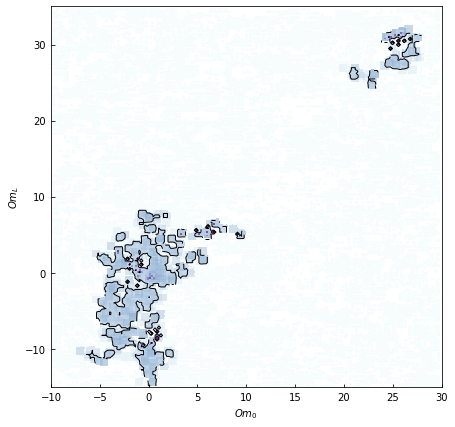

In [18]:
x1 = xchain[:,0]; x2 = xchain[:,1]

conflevs = [0.6827, 0.9545]

plot_2d_dist(x1, x2, xlim=[-10,30], ylim =[-15,35], nxbins=200, nybins=200, 
             clevs=conflevs, smooth=4, xlabel='$Om_0$', ylabel='$Om_L$', figsize=(7,7))

## Task 1e

In [13]:
def auto_corr_func(timeseries, lagmax):
    """
    compute auto correlation function
    """
    ts = np.asarray(timeseries)
    N = np.size(ts) - 1
    ts -= np.average(ts) # Set to mean 0
    corr_func = np.zeros(lagmax)
    for dt in range(lagmax):
        # sum of ts[t+dt]*ts[t]
        corr_func[dt] = (np.dot(timeseries[0:N-dt],timeseries[dt:N])) 
    if (corr_func[0]>0):
        corr_func /= corr_func[0] # normalize
    return corr_func

def compute_tcorr(timeseries,maxcorr):
    """
    compute auto-correlation time
    Parameters:
    -----------
    
    timeseries: 1d vector of values
    maxcorr: maximum autocorrelation lag to consider
    
    Returns:
    tau, mean, sigma: float scalars
        autocorrelation time, mean of the sequence and its rms 
    """
    timeseries = np.copy(timeseries)
    mean = np.average(timeseries)
    corrfxn = auto_corr_func(timeseries,maxcorr)
    tau = np.sum(corrfxn)-1
    var = np.var(timeseries)
    sigma = np.sqrt(var * tau / len(timeseries))
    return tau, mean, sigma

In [14]:
ndim = 5
nwalkers = 100
nsteps = 1000
step = 1.
args0 = []

#differential evolution yielded [ 0.25747937,  0.63495553, 24.07862841,  0.11942547,  2.5793592 ]
x0 = np.zeros((ndim, nwalkers))
for i in range(nwalkers):
    x0[0][i] = np.random.normal(0,1) + 0.25747937
    x0[1][i] = np.random.normal(0,1) + 0.63495553
    x0[2][i] = np.random.normal(0,1) + 24.07862841
    x0[3][i] = np.random.normal(0,1) + 0.11942547
    x0[4][i] = np.random.normal(0,1) + 2.5793592

step = 1.
chain1, pacc1 = vectorized_mcmc(x0, nsteps=nsteps, step=step, modelpdf = posterior_pdf, args = args0 )
step = 0.1
chain01, pacc01 = vectorized_mcmc(x0, nsteps=nsteps, step=step, modelpdf = posterior_pdf, args = args0 )
step = 10.
chain10, pacc10 = vectorized_mcmc(x0, nsteps=nsteps, step=step, modelpdf = posterior_pdf, args = args0 )

chain1 = np.array(chain1).flatten()
chain01 = np.array(chain01).flatten()
chain10 = np.array(chain10).flatten()

In [15]:
print(pacc1)
print(pacc01)
print(pacc10)

0.1054
0.7462
0.0


In [16]:
print("CHAIN 1")
print(np.size(np.unique(np.array(chain1))))
print(np.size(chain1))
print('CHAIN 01')
print(np.size(np.unique(np.array(chain01))))
print(np.size(chain01))
print("CHAIN 10")
print(np.size(np.unique(np.array(chain10))))
print(np.size(chain10))

CHAIN 1
53000
500500
CHAIN 01
373200
500500
CHAIN 10
500
500500


In [17]:
maxlag = 1000
tcorr1, mean1, sig1 = compute_tcorr(chain1,maxlag)
tcorr01, mean01, sig01  = compute_tcorr(chain01,maxlag)
tcorr10, mean10, sig10 = compute_tcorr(chain10,maxlag)
print("s=0.1: auto-correlation time %.3g"%tcorr1)
print("s=1: auto-correlation time %.3g"%tcorr01)
print("s=10: auto-correlation time %.3g"%tcorr10)

s=0.1: auto-correlation time -0.987
s=1: auto-correlation time -0.999
s=10: auto-correlation time -0.999


C:\Users\sadie\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
